In [1]:
# regression - validation in different floor number and building number
# import
import csv
import math
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
%matplotlib inline

random.seed

<bound method Random.seed of <random.Random object at 0x10401aa18>>

In [2]:
lati_range = []
long_range = []
for floor in range(2,3):
    for building in range(0,1):
        data_num = 0
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                long_range.append(float(row[520]))
                lati_range.append(float(row[521]))
                
        mid_long = (max(long_range) + min(long_range))/2
        mid_lati = (max(lati_range) + min(lati_range))/2
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                if (float(row[520]) > mid_long):
                    continue
                if (float(row[521]) > mid_lati):
                    continue
                data_num += 1

        print(data_num)
        if (data_num == 0):
            continue
        i = -1

        wifi_loc_time = np.zeros(shape = (data_num, 524))
        wifi = np.zeros(shape = (data_num, 520))
        longitude = np.zeros(shape=(data_num,2))

        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                if (float(wifi_loc_time[i][520]) > mid_long):
                    continue
                if (float(wifi_loc_time[i][521]) > mid_lati):
                    continue
                i = i+1
                if (i > data_num):
                    break
                # wifi
                wifi_loc_time[i-1][:520] = np.array(row[:520])
                wifi[i-1][:] = np.array(row[:520])
                # location x, y
                wifi_loc_time[i-1][520:522] = np.array(row[520:522])
                longitude[i-1][:] = np.array(row[520:522])
                # userID
                wifi_loc_time[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time[i-1][-1] = np.array(row[-1])
        # Testing
        # extract data
        data_num_v = 0 # 86 in validation dataset
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                if (float(row[520]) > mid_long):
                    continue
                if (float(row[521]) > mid_lati):
                    continue
                data_num_v += 1

        print(data_num_v)
        if (data_num_v == 0):
            continue
        i = -1

        wifi_loc_time_v = np.zeros(shape = (data_num_v, 524))
        wifi_v = np.zeros(shape = (data_num_v, 520))
        longitude_v = np.zeros(shape=(data_num_v,2))

        # 520 WAP
        # FLOOR 2
        # Building 1
        # timestamp

        # total data num = 19938

        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                if (float(wifi_loc_time_v[i][520]) > mid_long):
                    continue
                if (float(wifi_loc_time_v[i][521]) > mid_lati):
                    continue
                i = i+1
                #if (i > data_num):
                #    break
                # wifi
                wifi_loc_time_v[i-1][:520] = np.array(row[:520])
                wifi_v[i-1][:] = np.array(row[:520])
                # location x, y
                wifi_loc_time_v[i-1][520:522] = np.array(row[520:522])
                longitude_v[i-1][:] = np.array(row[520:522])
                # userID
                wifi_loc_time_v[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time_v[i-1][-1] = np.array(row[-1])

        kernel = 1.0 * RationalQuadratic(length_scale=23.0, alpha=0.999)
        gp = GaussianProcessRegressor(kernel=kernel, alpha=0.5).fit(wifi, longitude)
        loc_pred, loc_cov = gp.predict(wifi_v, return_cov=True)
        RMSE = 0
        for i in range(len(loc_pred)):
                        #print(loc_pred[i,0], longitude_v[i,0], loc_pred[i,0]-longitude_v[i,0])
                        #print(loc_pred[i,1], longitude_v[i,1], loc_pred[i,1]-longitude_v[i,1])
                        #print(math.sqrt(pow(loc_pred[i,0]-longitude_v[i,0],2)+pow(loc_pred[i,1]-longitude_v[i,1],2)))
            RMSE+=math.sqrt(pow(loc_pred[i,0]-longitude_v[i,0],2)+pow(loc_pred[i,1]-longitude_v[i,1],2))
        print(floor, building, RMSE/data_num_v)

558
65
2 0 0.0


In [3]:
# from sklearn.decomposition import PCA, KernelPCA

In [4]:
# n_components = 2
# # pca = PCA(n_components=n_components)
# # wifi_pca = pca.fit_transform(wifi)
# kpca = KernelPCA(kernel="rbf", n_components=2, gamma=100)
# wifi_pca = kpca.fit_transform(wifi)

In [5]:
# for i in range(len(wifi)):
#     axes = plt.gca()
#     axes.set_xlim([min(wifi_pca[:,0]),max(wifi_pca[:,0])])
#     axes.set_ylim([min(wifi_pca[:,1]),max(wifi_pca[:,1])])
#     plt.scatter(wifi_pca[:,0], wifi_pca[:,1], c='r')
#     plt.annotate(i, (wifi_pca[i,0], wifi_pca[i,1]))
#     plt.show()

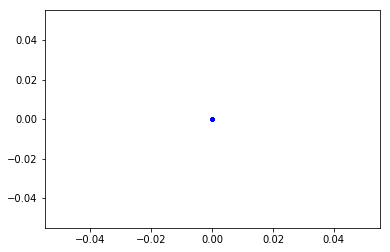

In [3]:
plt.plot(longitude[:,0], longitude[:,1], 'b.')

In [7]:
# print(wifi_pca)

In [8]:
# print(longitude)

In [9]:
# wifi_pca_v = kpca.fit_transform(wifi_v)
# for kernel in kernels:
#     gp = GaussianProcessRegressor(kernel=kernel,
#                                       alpha=0.5).fit(wifi_pca, longitude)
#     loc_pred, loc_cov = gp.predict(wifi_pca_v, return_cov=True)
#     RMSE = 0
#     for i in range(len(loc_pred)):
#             #print(loc_pred[i,0], longitude_v[i,0], loc_pred[i,0]-longitude_v[i,0])
#             #print(loc_pred[i,1], longitude_v[i,1], loc_pred[i,1]-longitude_v[i,1])
#             #print(math.sqrt(pow(loc_pred[i,0]-longitude_v[i,0],2)+pow(loc_pred[i,1]-longitude_v[i,1],2)))
#         RMSE+=math.sqrt(pow(loc_pred[i,0]-longitude_v[i,0],2)+pow(loc_pred[i,1]-longitude_v[i,1],2))
#     print(RMSE/data_num_v)

In [10]:
print(1e+05)

100000.0
